Category 5 of the TF certification exam is a sequence model with a real-world numeric dataset. This notebook covers preparing time-series data using windowing, as well as the structure for an effective prediction model.

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

from tensorflow import keras as k

TensorFlow 2.x selected.


In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-03-19 12:13:12--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c10::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0s      

2020-03-19 12:13:13 (148 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



The sunspots Kaggle dataset is used for this notebook. It is a csv file containing 3 values, the first corresponds to the timestep, the second is the date the measurement was taken and the third is the average number of sunspots over that period.

We use the python csv reader for this, but we could just as easily use pandas.

In [0]:
sunspots = []
timesteps = []

# Build data
with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    timesteps.append(int(row[0]))
    
# Cast to array
series = np.array(sunspots)
steps = np.array(timesteps)

In [0]:
# How many time steps to use for training
split_time = 3000

# Split train/val on this
time_train = steps[:split_time]
x_train = series[:split_time]

time_val = steps[split_time:]
x_val = series[split_time:]

Tensorflow datasets have the `window` method which conviently creates windowed batches of our data. For example, suppose our dataset was:

[1, 2, 3, 4, 5, 6, 7, 8]

The `window_size` specifies the size of the window, the `shift` specifies the stride. Drop remainder drops batches which are smaller than the `window_size`. So, if we have a window size of 5, and a stride of 1, we will produce the following:

[1, 2, 3, 4, 5]

[2, 3, 4, 5, 6]

[3, 4, 5, 6, 7]

etc.

This is returned as a dataset of datasets, which can be mapped to a single batched dataset using the `flat_map` method.

The reason we are adding 1 to the window_size is the final value is what we aim to predict.

In [0]:
def window_ds(series, window_size, batch_size, shuffle_buffer):
  # Expand dim for passing to Conv1D
  series = tf.expand_dims(series, axis=-1)
  # Build ds from tensor slices
  ds = tf.data.Dataset.from_tensor_slices(series)
  # Create a window dataset, drop batches smaller than the window size
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  # window returns a dataset of datasets, flat_map casts this to
  # a single dataset conveniently
  ds = ds.flat_map(lambda win: win.batch(window_size + 1))
  # Must shuffle - we don't want the time series in sequential order
  ds = ds.shuffle(shuffle_buffer)
  # Map first X elements as input, last element as output
  ds = ds.map(lambda win: (win[:-1], win[-1:]))
  # Batch the data and prefetch a single batch
  return ds.batch(batch_size).prefetch(1)

In [0]:
# Clears internal variables
tf.keras.backend.clear_session()
# Reproducibility
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256
buffer_size = 1000

window_train = window_ds(x_train, window_size, batch_size, buffer_size)

To effectively model temporal data, we make use of 1D convolutions, as well as LSTMs and fully connected layers. One could remove the convolution layer, but the overall testing error increases.

The keras `Lambda` layer is a nifty trick for using lamda functions inside our model. The predictions range up to about 400, so it would be beneficial to manually multiply this, so that the rest of the model can work with smaller values (as opposed to having to predict a larger value at the end, it can predict a smaller value which we will multiply).

In [0]:
model = k.models.Sequential([
    # One should always use causal padding for temporal data
    # see here: https://arxiv.org/abs/1609.03499
    # (causal only available to Conv1D)
    k.layers.Conv1D(filters = 32, kernel_size=5, strides=1,
                    padding='causal', activation='relu',
                    input_shape=[None, 1]),
    # Return sequences when passing to another LSTM
    k.layers.LSTM(64, return_sequences=True),
    k.layers.LSTM(64),
    k.layers.Dense(30, activation="relu"),
    k.layers.Dense(10, activation="relu"),
    k.layers.Dense(1),
    # You can (and should) experiment with removing this layer
    # to see the impact on training.
    k.layers.Lambda(lambda x: x * 400)
])

We now define a learning rate scheduler callback. This will train the model using various learning rates, with the goal being to determine which LR is the optimal. We begin with a LR of `1e-7` and increment it slowly over 100 epochs until we reach `1e-2`. After this we will plot the loss for each LR, and use the plot to pick an optimal value. This obviously isn't needed all the time (get it), but time series are often fragile and we should try find an optimal value without just taking a blind guess.

In [0]:
# LR scheduler for finding optimal LR
lr_schedule = k.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))

In [0]:
# The course uses SGD here but I found Adam resulted in 
# a lower mae and much quicker convergence
optimizer = k.optimizers.Adam(lr=1e-7)

model.compile(loss=k.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [0]:
# Will take some time, set verbose=1 to see loss at each epoch
history = model.fit(window_train, epochs=100, callbacks=[lr_schedule], verbose=0)

We now plot the LR vs loss, we can see a LR between `1e-4` and `1e-3` would be sufficient. Anything greater and we begin to see instability, which we obviously do not want. Let us choose `1e-3`.

(1e-07, 0.01, 0.0, 100.0)

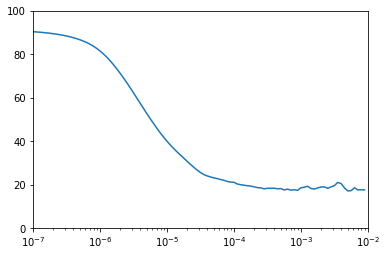

In [27]:
# Plot the LR vs Loss to pick an optimal value
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-2, 0, 100])

Now that we have chosen an optimal LR, we recreate our model and train it using this LR.

In [0]:
# Clears internal variables
tf.keras.backend.clear_session()
# Reproducibility
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256
buffer_size = 1000

window_train = window_ds(x_train, window_size, batch_size, buffer_size)

In [0]:
model = k.models.Sequential([
    k.layers.Conv1D(filters = 32, kernel_size=5, strides=1,
                    padding='causal', activation='relu',
                    input_shape=[None, 1]),
    # Return sequences when passing to another LSTM
    # One could also make this bidirectional
    k.layers.LSTM(64, return_sequences=True),
    k.layers.LSTM(64),
    k.layers.Dense(30, activation="relu"),
    k.layers.Dense(10, activation="relu"),
    k.layers.Dense(1),
    k.layers.Lambda(lambda x: x * 400)
])

In [0]:
optimizer = k.optimizers.Adam(lr=1e-3)


model.compile(loss=k.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [12]:
history = model.fit(window_train, epochs=100)

Epoch 1/100
12/12 [==============================] - 7s 565ms/step - loss: 41.7824 - mae: 43.1454
Epoch 2/100
12/12 [==============================] - 4s 349ms/step - loss: 23.0706 - mae: 23.7757
Epoch 3/100
12/12 [==============================] - 4s 350ms/step - loss: 19.7744 - mae: 20.3395
Epoch 4/100
12/12 [==============================] - 4s 346ms/step - loss: 18.0418 - mae: 18.4824
Epoch 5/100
12/12 [==============================] - 4s 346ms/step - loss: 18.2148 - mae: 18.6802
Epoch 6/100
12/12 [==============================] - 4s 350ms/step - loss: 19.2087 - mae: 19.8151
Epoch 7/100
12/12 [==============================] - 4s 349ms/step - loss: 18.0499 - mae: 18.4758
Epoch 8/100
12/12 [==============================] - 4s 350ms/step - loss: 17.7227 - mae: 18.1785
Epoch 9/100
12/12 [==============================] - 4s 351ms/step - loss: 17.3860 - mae: 17.8892
Epoch 10/100
12/12 [==============================] - 4s 351ms/step - loss: 17.4437 - mae: 17.9549
Epoch 11/100
12/12 

With the model trained we are ready for prediction. 

In [0]:
def model_forecast(model, series, window_size):
    # For generating the prediction forecast of our model
    ds = tf.data.Dataset.from_tensor_slices(series)
    # Don't need to add 1 to window_size as we are not splitting
    # into input/output
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    # Get prediction
    forecast = model.predict(ds)

    return forecast

In [0]:
# Pass the series to the model, adding an extra dimension in the process
forecast = model_forecast(model, series[..., np.newaxis], window_size)
# We are interested in how well the model predicts on data it has
# not yet seen, so we remove the training period it was trained over
val_forecast = forecast[split_time - window_size:-1, -1]

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

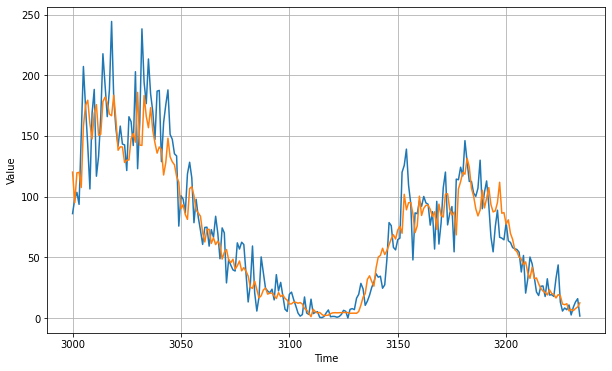

In [16]:
# Plot the forecast against the actual values
plt.figure(figsize=(10, 6))
plot_series(time_val, x_val)
plot_series(time_val, val_forecast)

In [17]:
# Check what our mae is against the validation period
tf.keras.metrics.mean_absolute_error(x_val, val_forecast).numpy()

14.639927

And finally, as usual, we can plot the results of our training.

<Figure size 432x288 with 0 Axes>

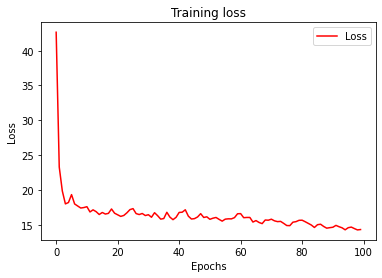

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.image  as mpimg

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()
